# 운동 시계열 데이터 분석
<br>
운동 자세를 판단하는 모델을 만들기 위해선 먼저 각 운동의 한번의 반복을 구분할 필요가 있다.<br>
따라서 운동영상을 반복동작 1번으로 나누는 코드를 만들어야 한다.<br>

## 1. 라이브러리 import

In [1]:
import os
from scipy import io
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from IPython.core.display import display, HTML

display(HTML("<style> .container{width:90% !important;}</style>"))

## 2. 데이터 로드 & numpy array 추출

- 데이터는 [UTD-MHAD](https://personal.utdallas.edu/~kehtar/UTD-MHAD.html)를 활용
- ai_sj_tk_skeleton.mat : j번째 사람의 i번 행동의 t번째 반복<br>
- 예를 들어 a27_s6_t1_skeleton은 6번사람이 27번째 동작(스쿼트)를 한번만 한 것<br>
- 운동을 할때 각 반복을 끊는 프레임을 알고 싶기 때문에<br>
- 같은 사람이 한 같은 행동 4개를 하나의 array로 묶고서<br>
- 반복을 나누는 프레임 위치를 예측한다<br>
- rep_cutter : 반복동작을 나누는 프레임

In [10]:
# skel_mat = io.loadmat(os.getcwd() + f'/skeleton/a27_s6_t1_skeleton.mat')
# skeleton = skel_mat['d_skel']
# rep_cutter = [skeleton.shape[2]] # 한 반복이 끝나는 지점
# for i in range(2, 5):
#     skel_mat = io.loadmat(os.getcwd() + f'/skeleton/a27_s6_t{i}_skeleton.mat')
#     tmp = skel_mat['d_skel']
#     skeleton = np.concatenate((skeleton, tmp), axis = 2)
#     rep_cutter.append(skeleton.shape[2])

path = './output/squat_skeleton_10_1.csv'
# path = './input/squat_skeleton_10.csv'
# path = 'total.csv'
skeleton = pd.read_csv(path).to_numpy()
print(skeleton.shape)
# print(rep_cutter)

(79, 31)


- x_sk, y_sk, z_sk : x좌표, y좌표, z좌표<br>
- y축의 경우는 뒤집혀져 있다. (아래쪽이 머리, 위쪽이 다리) -> -를 씌워 뒤집음<br>

In [11]:
x_sk = skeleton[:,1:15]
y_sk = skeleton[:, 16:30]
# z_sk = skeleton[:, 2, :]
# xmax = np.max(x_sk)
# ymax = np.max(y_sk)
# # zmax = np.max(z_sk)
# xmin = np.min(x_sk)
# ymin = np.min(y_sk)
# # zmin = np.min(z_sk)
# x_diff = xmax - xmin
# y_diff = ymax - ymin
# # z_diff = zmax - zmin
# print(xmax, ymax, zmax)
# print(xmin, ymin, zmin)
print(x_sk.shape, y_sk.shape)

(79, 14) (79, 14)


## 3. 데이터 리스케일 & 이미지화

- 점들이 표준화 되어 있어서 비디오 크기만큼 rescale<br>
- rescale : x~ : 리스케일, x : 표준화된 좌표, scale_range : 스케일링 범위<br>
x~ = (x - x_min) * scale_range / (x_max - x_min)

In [12]:
# 비디오 크기
height = 600
width = 480

right = [8,9,10]
left = [11,12,13]
rcolor = [255,0,0] #blue
lcolor = [0,0,255] #red

# 평행이동 변수
lrmove = -120
udmove = 0

# 동영상 포맷, 경로
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter(
    'cutting.avi', fourcc, 30.0, (width, height))
for frame in range(0, skeleton.shape[0]):
    img = np.empty((height, width, 3), dtype='uint8')
    img.fill(255)
    x = x_sk[frame]
    y = y_sk[frame]
#     z = ((z_sk[:,frame] - zmin) * width / z_diff).astype('int32')
#     y = ((y_sk[:, frame] - ymin) * height / y_diff).astype('int32')

    for i in range(0, 14):
        if i in right:
            cv2.circle(img, (int(x[i]) + lrmove, int(y[i]) + udmove), 2, rcolor, -1)
        elif i in left:
            cv2.circle(img, (int(x[i]) + lrmove, int(y[i])+ udmove), 2, lcolor, -1)
        else:
            cv2.circle(img, (int(x[i]) + lrmove, int(y[i])+ udmove), 2, (0, 0, 0), -1)
#         print(x[i], y[i])
    cv2.imshow('test', img)
    out.write(img)
    cv2.waitKey(30)
out.release()
cv2.destroyAllWindows()

# 4. 반복동작을 나누는 지점 찾기

- 실제로 분석할 때는 표준화된 데이터를 사용(리스케일 안함)<br>
- 엉덩이 포인트의 y값을 기준으로

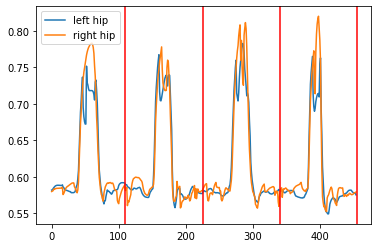

In [5]:
left_hip = y_sk[13]
right_hip = y_sk[17]
plt.plot(left_hip, label = 'left hip')
plt.plot(right_hip, label = 'right hip')
for c in rep_cutter:
    plt.axvline(x = c, color = 'red')
plt.legend()
plt.show()

- 빨간 선 : 반복동작이 나뉘어지는 프레임
- 데이터의 진동이 심하므로 지수가중평균을 사용하여 진동을 줄임
- 왼쪽, 오른쪽 엉덩이의 높이차가 존재 -> 둘의 평균을 사용
- 정확한 자세측정이 목표가 아니라 그냥 나누는 지점을 찾기 위한 것
- 한쪽 엉덩이만 사용해도 됨

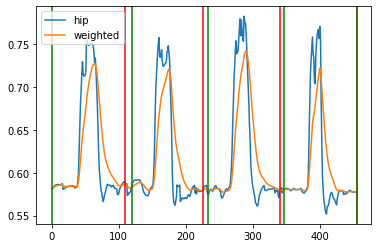

rep cutter : [110, 226, 341, 455]
predicted cutter : [0, 120, 233, 346, 455]


In [6]:
# 왼쪽, 오른쪽 엉덩이 평균 구하기
hip = (left_hip + right_hip) / 2

# 동작을 구분해줄 수 있는 (특징적인) 극점 검출을 위한 리스트와 변수
feature_maxima = []
feature_minima = []
total_avg = np.average(hip)
prev = 0
flag = 'up'

# 지수 가중 평균
beta = 0.9 # 1 / (1 - 0.9) 프레임 전부터 지금까지의 평균을 낸다
weighted_avg = [0]
for t in range(1, hip.shape[0]):
    curr = beta * weighted_avg[-1] + (1 - beta) * hip[t]
    weighted_avg.append(curr)
    # 극점 찾기
    if flag == 'up' and prev > curr and total_avg < prev:
        feature_maxima.append(t-1)
        flag = 'down'
    elif flag == 'down' and prev < curr and total_avg > prev:
        feature_minima.append(t-1)
        flag = 'up'
    prev = curr
for t in range(1, hip.shape[0]):
    weighted_avg[t] /= 1 - beta**t

# 동작 구분 프레임 예측
predicted_cutter = [0]
for i in range(len(feature_maxima)-1):
    predicted_cutter.append(int((feature_maxima[i] + feature_maxima[i+1]) / 2))
predicted_cutter.append(skeleton.shape[2])

plt.plot(hip, label = 'hip')
plt.plot(weighted_avg[1:], label = 'weighted')
for c in rep_cutter:
    plt.axvline(x = c, color = 'red')
for p in predicted_cutter:
    plt.axvline(x = p, color = 'green')
plt.legend()
plt.show()
print('rep cutter :', rep_cutter)
print('predicted cutter :', predicted_cutter)

In [7]:


height = 300
width = 200;
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
for i in range(0, len(predicted_cutter) - 1):
    start_frame = predicted_cutter[i]
    end_frame = predicted_cutter[i+1];
    out = cv2.VideoWriter(
        f'predicted/predicted_{i+1}.avi', fourcc, 30.0, (width, height))
    for frame in range(start_frame, end_frame):
        img = np.empty((height, width, 3), dtype='uint8')
        img.fill(255)

        z = ((z_sk[:,frame] - zmin) * width / z_diff).astype('int32')
        y = ((y_sk[:, frame] - ymin) * height / y_diff).astype('int32')

        for i in range(0, 20):
            cv2.circle(img, (z[i], y[i]), 2, (0, 0, 0), -1)
        out.write(img)
    out.release()
    

- <font color = 'red'>빨간</font> 수직선은 원래 한번씩 분할된 영상들을 구분한 선이고
- <font color = 'green'>녹색</font> 수직선은 하나로 연결한 영상들에서 스쿼트 1회를<br>구분하는 프레임을 예측한 것이다.